---
# Bulk processing Sentinel products to PNG images

---
Sent2 DB:
https://www.indexdatabase.de/db/s-single.php?id=96

SentPlayground:
https://apps.sentinel-hub.com/sentinel-playground/

List:
https://forum.step.esa.int/t/list-of-band-combinations-for-sentinel-2/1156/6


In [1]:
import geopandas as gpd
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio as rio
from rasterio import plot
import rasterio.mask
from skimage import exposure
from pathlib import Path

In [2]:
# Load polygon vector
boundsdata = r'../data/SouthMalta.geojson'
region = gpd.read_file(boundsdata)
region

nReserve_proj = region.to_crs({'init': 'epsg:32633'})

p = ('../data/selecteddata/Viva Showcase Data')

C:\Users\MCAST\anaconda3\envs\remsen\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


---
# RGB (2,3,4)
---

 Viva Showcase Data
--- S2A_MSIL1C_20210504T094031_N0300_R036_T33SVV_20210504T105322.SAFE
------ AUX_DATA
------ DATASTRIP
--------- DS_VGS4_20210504T105322_S20210504T094344
------------ QI_DATA
------ GRANULE
--------- L1C_T33SVV_A030635_20210504T094344
------------ AUX_DATA
------------ IMG_DATA
--------------- T33SVV_20210504T094031_B01.jp2
--------------- T33SVV_20210504T094031_B02.jp2
--------------- T33SVV_20210504T094031_B03.jp2
--------------- T33SVV_20210504T094031_B04.jp2
--------------- T33SVV_20210504T094031_B05.jp2
--------------- T33SVV_20210504T094031_B06.jp2
--------------- T33SVV_20210504T094031_B07.jp2
--------------- T33SVV_20210504T094031_B08.jp2
--------------- T33SVV_20210504T094031_B09.jp2
--------------- T33SVV_20210504T094031_B10.jp2
--------------- T33SVV_20210504T094031_B11.jp2
--------------- T33SVV_20210504T094031_B12.jp2
--------------- T33SVV_20210504T094031_B8A.jp2
--------------- T33SVV_20210504T094031_TCI.jp2
1
10980
10980
uint16
EPSG:32633
| 10.00, 0.

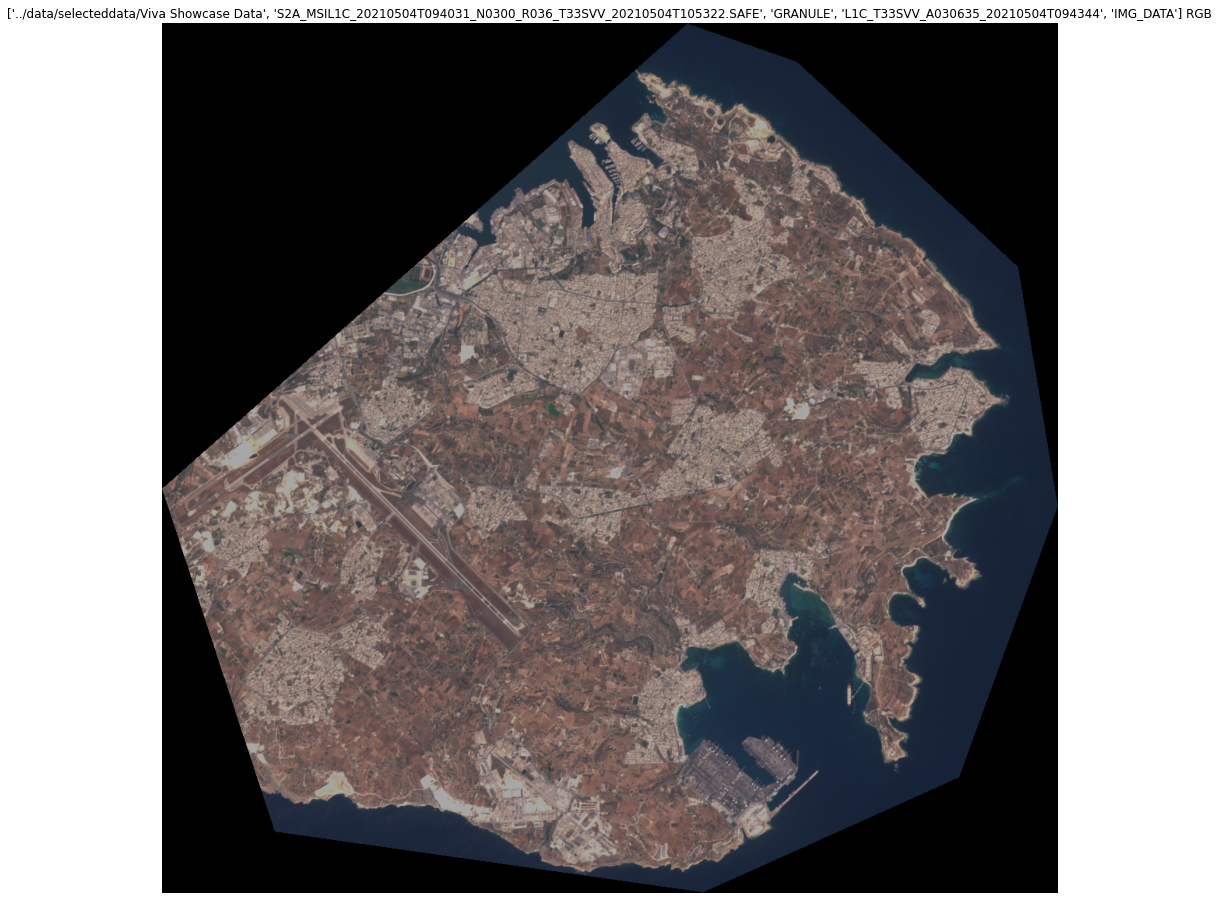

------------ QI_DATA
------ HTML
------ rep_info


In [3]:
path = Path(p)
k=0
# traverse root directory, and list directories as dirs and files as files
for root, dirs, files in os.walk(p):
    path = root.split(os.sep)
    print((len(path) - 1) * '---', os.path.basename(root))


    #print(path[:6])

    if os.path.basename(root) == 'IMG_DATA':
        k+=1
        for file in files:
            print(len(path) * '---', file)

            if 'B02' in file: band2 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #blue
            #if 'B02_20m' in file: band2 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #blue

            if 'B03' in file: band3 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #green
            #if 'B03_20m' in file: band3 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #green

            if 'B04' in file: band4 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #red
            #if 'B04_20m' in file: band4 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #red

            #if 'B08' in file: band8 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #nir

        if band2 is not None:
            #number of raster bands
            print(band2.count)
            #number of raster columns
            print(band2.width)
            #number of raster rows
            print(band2.height)

            #type of raster byte
            print(band2.dtypes[0])
            #raster sytem of reference
            print(band2.crs)
            #raster transform parameters
            print(band2.transform)

            #export true color image
            trueColor = rasterio.open('../Output/CACHE/SentinelTemp.tiff','w',driver='Gtiff',
                                     width=band4.width, height=band4.height,
                                     count=3,
                                     crs=band4.crs,
                                     transform=band2.transform,
                                     dtype=band2.dtypes[0]
                                     )
            trueColor.write(band2.read(1),1) #blue
            trueColor.write(band3.read(1),2) #green
            trueColor.write(band4.read(1),3) #red
            trueColor.close()

            with rio.open("../Output/CACHE/SentinelTemp.tiff") as src:
                out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
                out_meta = src.meta.copy()
                out_meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform,
                             "dtype": "uint16"})




            # Rescale the image (divide by 10000 to convert to [0:1] reflectance
            image = np.array(out_image[[2,1,0], :, :])
            p2, p98 = np.percentile(image, (2,98))
            image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

            rgb = np.array(image.transpose(1,2,0))

            #Plot and save image with Matplotlib
            fig = plt.figure(figsize=(20,16))
            ax=fig.add_subplot(1,1,1)
            ax.set_title(str(path) +' RGB')
            #fig.suptitle("BOLD TITLE")
            plt.axis('off')
            plt.imshow(rgb)

            #Save scaled reflectance image
            # Call 'savefig' to save this plot to an image file
            file_to_save = 'HalFar_Rendered_' + str(k).zfill(3) +'.png'
            plt.savefig(os.path.join('../Output/PROCESSED', file_to_save), bbox_inches='tight', transparent=True, pad_inches=0)
            plt.show()

---
# SWIR (4, 8A, 12)(B12, B8A, B4)
---

 Viva Showcase Data
--- S2A_MSIL1C_20210504T094031_N0300_R036_T33SVV_20210504T105322.SAFE
------ AUX_DATA
------ DATASTRIP
--------- DS_VGS4_20210504T105322_S20210504T094344
------------ QI_DATA
------ GRANULE
--------- L1C_T33SVV_A030635_20210504T094344
------------ AUX_DATA
------------ IMG_DATA
--------------- T33SVV_20210504T094031_B01.jp2
--------------- T33SVV_20210504T094031_B02.jp2
--------------- T33SVV_20210504T094031_B03.jp2
--------------- T33SVV_20210504T094031_B04.jp2
--------------- T33SVV_20210504T094031_B05.jp2
--------------- T33SVV_20210504T094031_B06.jp2
--------------- T33SVV_20210504T094031_B07.jp2
--------------- T33SVV_20210504T094031_B08.jp2
--------------- T33SVV_20210504T094031_B09.jp2
--------------- T33SVV_20210504T094031_B10.jp2
--------------- T33SVV_20210504T094031_B11.jp2
--------------- T33SVV_20210504T094031_B12.jp2
--------------- T33SVV_20210504T094031_B8A.jp2
--------------- T33SVV_20210504T094031_TCI.jp2
1
10980
10980
uint16
EPSG:32633
| 10.00, 0.

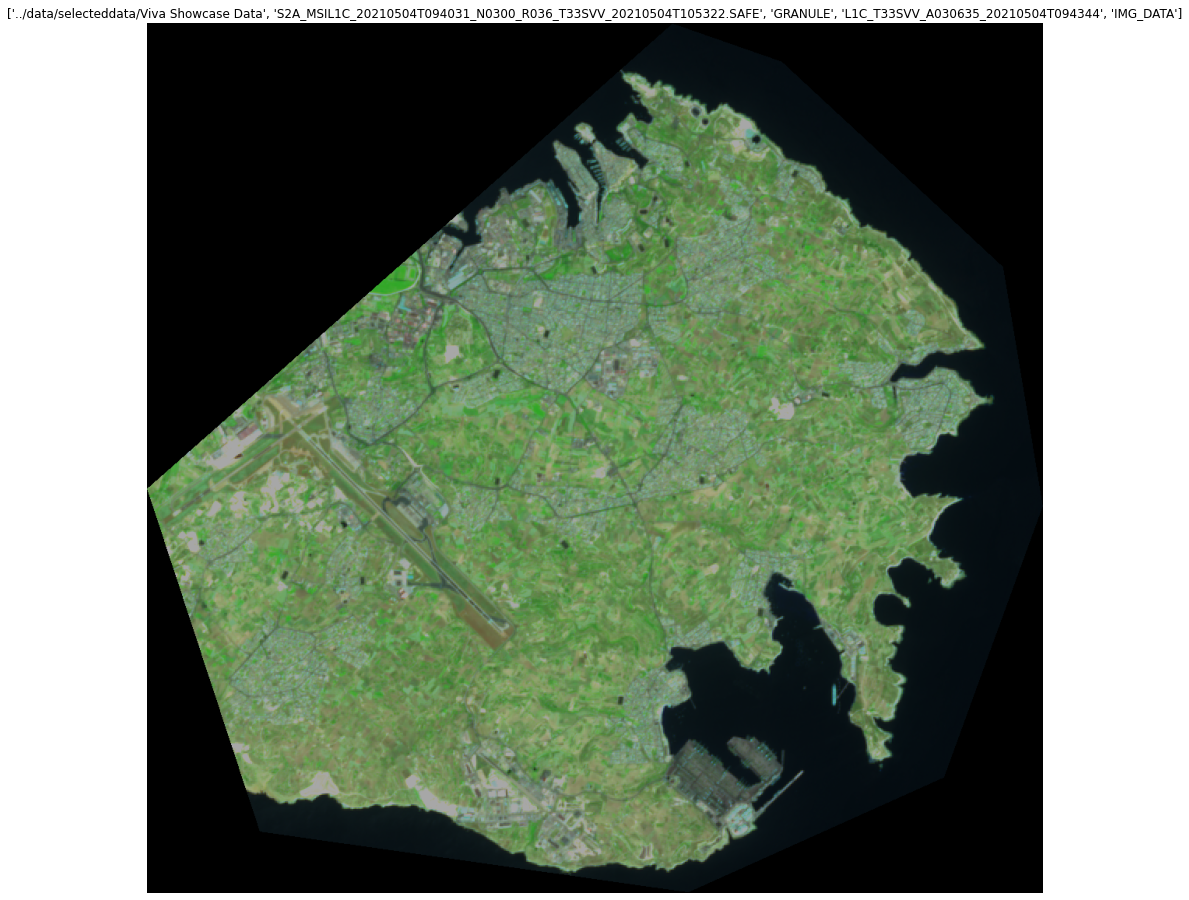

------------ QI_DATA
------ HTML
------ rep_info


In [4]:
path = Path(p)
k=0
# traverse root directory, and list directories as dirs and files as files
for root, dirs, files in os.walk(p):
    path = root.split(os.sep)
    print((len(path) - 1) * '---', os.path.basename(root))

    if os.path.basename(root) == 'IMG_DATA':
        k+=1
        for file in files:
            print(len(path) * '---', file)

            if 'B04' in file: band2 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #blue
            #if 'B04_20m' in file: band2 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #blue

            if 'B8A' in file: band3 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #green
            #if 'B8A_20m' in file: band3 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #green

            if 'B12' in file: band4 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #red
            #if 'B12_20m' in file: band4 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #red

            #if 'B08' in file: band8 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #nir

        if band2 is not None:
            #number of raster bands
            print(band2.count)
            #number of raster columns
            print(band2.width)
            #number of raster rows
            print(band2.height)

            #type of raster byte
            print(band2.dtypes[0])
            #raster sytem of reference
            print(band2.crs)
            #raster transform parameters
            print(band2.transform)

            #export true color image
            SwirColour = rasterio.open('../Output/CACHE/SentinelTemp.tiff','w',driver='Gtiff',
                                     width=band2.width, height=band2.height,
                                     count=3,
                                     crs=band2.crs,
                                     transform=band2.transform,
                                     dtype=band2.dtypes[0]
                                     )
            SwirColour.write(band2.read(1),1) #blue
            SwirColour.write(band3.read(1),2) #green
            SwirColour.write(band4.read(1),3) #red
            SwirColour.close()

            nReserve_proj = region.to_crs({'init': 'epsg:32633'})

            with rio.open("../Output/CACHE/SentinelTemp.tiff") as src:
                out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
                out_meta = src.meta.copy()
                out_meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform,
                             "dtype": "uint16"})




            # Rescale the image (divide by 10000 to convert to [0:1] reflectance
            image = np.array(out_image[[2,1,0], :, :])
            p2, p98 = np.percentile(image, (2,98))
            image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

            rgb = np.array(image.transpose(1,2,0))

            #Plot and save image with Matplotlib
            fig = plt.figure(figsize=(20,16))
            ax=fig.add_subplot(1,1,1)
            ax.set_title(str(path))
            plt.axis('off')
            plt.imshow(rgb)

            #Save scaled reflectance image
            # Call 'savefig' to save this plot to an image file
            file_to_save = 'SWIR_Rendered_' + str(k).zfill(3) +'.png'
            plt.savefig(os.path.join('../Output/PROCESSED', file_to_save), bbox_inches='tight', transparent=True, pad_inches=0)
            plt.show()

---
# FalseColour Urban (12,11,4)
---

 Viva Showcase Data
--- S2A_MSIL1C_20210504T094031_N0300_R036_T33SVV_20210504T105322.SAFE
------ AUX_DATA
------ DATASTRIP
--------- DS_VGS4_20210504T105322_S20210504T094344
------------ QI_DATA
------ GRANULE
--------- L1C_T33SVV_A030635_20210504T094344
------------ AUX_DATA
------------ IMG_DATA
--------------- T33SVV_20210504T094031_B01.jp2
--------------- T33SVV_20210504T094031_B02.jp2
--------------- T33SVV_20210504T094031_B03.jp2
--------------- T33SVV_20210504T094031_B04.jp2
--------------- T33SVV_20210504T094031_B05.jp2
--------------- T33SVV_20210504T094031_B06.jp2
--------------- T33SVV_20210504T094031_B07.jp2
--------------- T33SVV_20210504T094031_B08.jp2
--------------- T33SVV_20210504T094031_B09.jp2
--------------- T33SVV_20210504T094031_B10.jp2
--------------- T33SVV_20210504T094031_B11.jp2
--------------- T33SVV_20210504T094031_B12.jp2
--------------- T33SVV_20210504T094031_B8A.jp2
--------------- T33SVV_20210504T094031_TCI.jp2
1
10980
10980
uint16
EPSG:32633
| 10.00, 0.

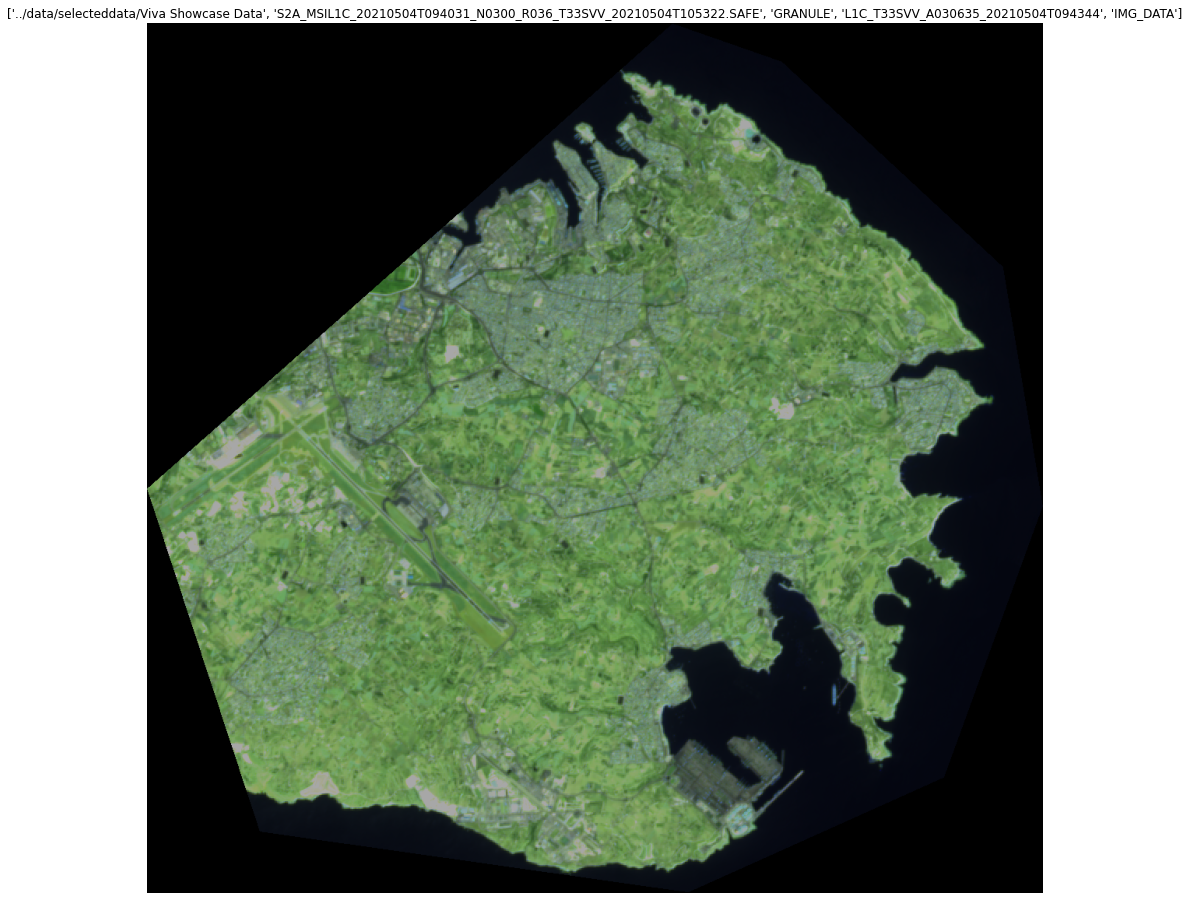

------------ QI_DATA
------ HTML
------ rep_info


In [5]:
path = Path(p)
k=0
# traverse root directory, and list directories as dirs and files as files
for root, dirs, files in os.walk(p):
    path = root.split(os.sep)
    print((len(path) - 1) * '---', os.path.basename(root))


    #print(path[:6])

    if os.path.basename(root) == 'IMG_DATA':
        k+=1
        for file in files:
            print(len(path) * '---', file)

            if 'B04' in file: band2 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG')

            if 'B11' in file: band3 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG')

            if 'B12' in file: band4 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG')

        if band2 is not None:
            #number of raster bands
            print(band2.count)
            #number of raster columns
            print(band2.width)
            #number of raster rows
            print(band2.height)

            #type of raster byte
            print(band2.dtypes[0])
            #raster sytem of reference
            print(band2.crs)
            #raster transform parameters
            print(band2.transform)

            #export true color image
            trueColor = rasterio.open('../Output/CACHE/SentinelTemp.tiff','w',driver='Gtiff',
                                     width=band2.width, height=band2.height,
                                     count=3,
                                     crs=band2.crs,
                                     transform=band2.transform,
                                     dtype=band2.dtypes[0]
                                     )
            trueColor.write(band2.read(1),1) #blue
            trueColor.write(band3.read(1),2) #green
            trueColor.write(band4.read(1),3) #red
            trueColor.close()

            with rio.open("../Output/CACHE/SentinelTemp.tiff") as src:
                out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
                out_meta = src.meta.copy()
                out_meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform,
                             "dtype": "uint16"})




            # Rescale the image (divide by 10000 to convert to [0:1] reflectance
            image = np.array(out_image[[2,1,0], :, :])
            p2, p98 = np.percentile(image, (2,98))
            image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

            rgb = np.array(image.transpose(1,2,0))

            #Plot and save image with Matplotlib
            fig = plt.figure(figsize=(20,16))
            ax=fig.add_subplot(1,1,1)
            ax.set_title(str(path))
            #fig.suptitle("BOLD TITLE")
            plt.axis('off')
            plt.imshow(rgb)

            #Save scaled reflectance image
            # Call 'savefig' to save this plot to an image file
            file_to_save = 'Urban_Rendered_' + str(k).zfill(3) +'.png'
            plt.savefig(os.path.join('../Output/PROCESSED', file_to_save), bbox_inches='tight', transparent=True, pad_inches=0)
            plt.show()

---
# NDBI = (B11-B8A)/(B11+B8A)
---

 Viva Showcase Data
--- S2A_MSIL1C_20210504T094031_N0300_R036_T33SVV_20210504T105322.SAFE
------ AUX_DATA
------ DATASTRIP
--------- DS_VGS4_20210504T105322_S20210504T094344
------------ QI_DATA
------ GRANULE
--------- L1C_T33SVV_A030635_20210504T094344
------------ AUX_DATA
------------ IMG_DATA
--------------- T33SVV_20210504T094031_B01.jp2
--------------- T33SVV_20210504T094031_B02.jp2
--------------- T33SVV_20210504T094031_B03.jp2
--------------- T33SVV_20210504T094031_B04.jp2
--------------- T33SVV_20210504T094031_B05.jp2
--------------- T33SVV_20210504T094031_B06.jp2
--------------- T33SVV_20210504T094031_B07.jp2
--------------- T33SVV_20210504T094031_B08.jp2
--------------- T33SVV_20210504T094031_B09.jp2
--------------- T33SVV_20210504T094031_B10.jp2
--------------- T33SVV_20210504T094031_B11.jp2
--------------- T33SVV_20210504T094031_B12.jp2
--------------- T33SVV_20210504T094031_B8A.jp2
--------------- T33SVV_20210504T094031_TCI.jp2
float64


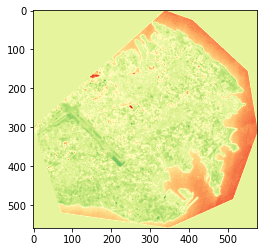

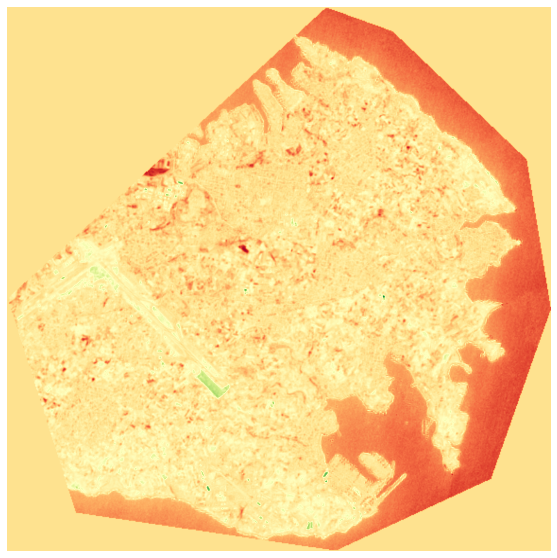

------------ QI_DATA
------ HTML
------ rep_info


In [6]:
path = Path(p)
k=0
# traverse root directory, and list directories as dirs and files as files
for root, dirs, files in os.walk(p):
    path = root.split(os.sep)
    print((len(path) - 1) * '---', os.path.basename(root))


    #print(path[:6])

    if os.path.basename(root) == 'IMG_DATA':
        k+=1
        for file in files:
            print(len(path) * '---', file)

            if 'B11' in file: band11 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG')

            if 'B8A' in file: band8A = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG')

        # read swir(b11) and NIR(b8A) as arrays
        swir = band11.read()
        nir = band8A.read()

        # Do not display error when divided by zero
        np.seterr(divide='ignore', invalid='ignore')

        # Calculate NDBI
        NDBI = (swir.astype(float)-nir.astype(float))/(swir+nir)

        # get the dtype of our NDBI array:
        NDBI_dtype = NDBI.dtype
        print(NDBI_dtype)

        # Write the NDBI image
        meta = band11.meta
        meta.update(driver='GTiff')
        meta.update(dtype=rasterio.float64)

        with rasterio.open('../Output/NDBI.tif', 'w', **meta) as dst:
            dst.write(NDBI)

        # Crop NDVI to ROI
        with rio.open("../Output/NDBI.tif") as src:
            out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
            out_meta = src.meta.copy()
            out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})

        with rasterio.open('../Output/NDBI_cropped.tif', 'w', **meta) as dst:
            dst.write(out_image)
        plot.show(out_image, cmap='RdYlGn')

        class MidpointNormalize(colors.Normalize):
            def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
                self.midpoint = midpoint
                colors.Normalize.__init__(self, vmin, vmax, clip)

            def __call__(self, value, clip=None):

                x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
                return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

        # Set min/max values from NDBI range for image
        min=np.nanmin(out_image)
        max=np.nanmax(out_image)

        # Set our custom midpoint for most effective NDBI analysis
        mid=0.1

        # Setting color scheme ref:https://matplotlib.org/users/colormaps.html as a reference
        colormap = plt.cm.RdYlGn
        norm = MidpointNormalize(vmin=min, vmax=max, midpoint=mid)
        fig = plt.figure(figsize=(20,10))


        ax = fig.add_subplot(111)

        ndvi_cropped = rasterio.open("../Output/NDBI_cropped.tif")
        # Use 'imshow' to specify the input data, colormap, min, max, and norm for the colorbar
        cbar_plot = ax.imshow(ndvi_cropped.read(1), cmap=colormap, vmin=min, vmax=max, norm=norm)


        # Turn off the display of axis labels
        ax.axis('off')

        # Call 'savefig' to save this plot to an image file
        fig.savefig("../Output/NDBI-image"+str(k) +".png", dpi=200, bbox_inches='tight', pad_inches=0.7)

        # let's visualize
        plt.show()